In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from collections import defaultdict

import json

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

import itertools

import random

from skimage import measure
import dill
import csv


In [10]:
def read_image(path):
    return plt.imread(path)

(480, 640)


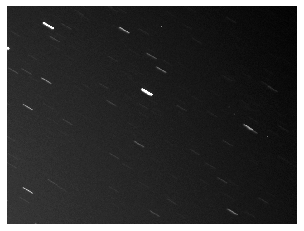

In [11]:
example_image=read_image('geoSatellites/train/1/1.png')
print(example_image.shape)
plt.imshow(example_image, cmap='gray')
plt.axis('off')
plt.show()

In [12]:
def read_annotation_file(path):
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict

train_annotation=read_annotation_file('geoSatellites/train_anno.json')

In [13]:
random.seed(0)

def random_different_coordinates(coords, size_x, size_y, pad,cond):
    """ Returns a random set of coordinates that is different from the provided coordinates, 
    within the specified bounds.
    The pad parameter avoids coordinates near the bounds."""
    good = False
    while not good:
        good = True
        c1 = random.randint(pad + 1, size_x - (pad + 1))
        c2 = random.randint(pad + 1, size_y -( pad + 1))
        if cond:
            for c in coords:
                coordset_0 = range(int(c[0])-1,int(c[0])+2)
                coordset_1 = range(int(c[1])-1,int(c[1])+2)
                if c1 in coordset_0 and c2 in coordset_1:
                    good = False
                    break
        else:
            for c in coords:
                if c1==c[0] and c2==c[1]:
                    good = False
                    break
    return (c1,c2)

def extract_neighborhood(x, y, arr, radius):
    """ Returns a 1-d array of the values within a radius of the x,y coordinates given """
    return arr[(x - radius) : (x + radius + 1), (y - radius) : (y + radius + 1)].ravel()

def check_coordinate_validity(x, y, size_x, size_y, pad):
    """ Check if a coordinate is not too close to the image edge """
    return x >= pad and y >= pad and x + pad < size_x and y + pad < size_y

def generate_labeled_data(image_path, annotation, nb_false, radius,cond):
    """ For one frame and one annotation array, returns a list of labels 
    (1 for true object and 0 for false) and the corresponding features as an array.
    nb_false controls the number of false samples
    radius defines the size of the sliding window (e.g. radius of 1 gives a 3x3 window)"""
    features,labels = [],[]
    im_array = read_image(image_path)
    # True samples
    for obj in annotation:
        obj = [int(x + .5) for x in obj] #Project the floating coordinate values onto integer pixel coordinates.
        # For some reason the order of coordinates is inverted in the annotation files
        if check_coordinate_validity(obj[1],obj[0],im_array.shape[0],im_array.shape[1],radius):
            features.append(extract_neighborhood(obj[1],obj[0],im_array,radius))
            labels.append(1)
            #features.append(extract_neighborhood(obj[1],obj[0],im_array,radius))
            #labels.append(1)
        if False:
            for k in range(obj[0]-1 , obj[0]+2):
                for l in range(obj[1]-1 , obj[1]+2):
                    if check_coordinate_validity(l,k,im_array.shape[0],im_array.shape[1],radius):
                        #if k!=obj[0] or l!=obj[1]:
                        randn = random.randint(1,9)
                        if randn % 2 == 0:
                            features.append(extract_neighborhood(l,k,im_array,radius))
                            labels.append(1)
    # False samples
    for i in range(nb_false):
        c = random_different_coordinates(annotation,im_array.shape[1],im_array.shape[0],radius,cond)
        features.append(extract_neighborhood(c[1],c[0],im_array,radius))
        labels.append(0)
    return np.array(labels),np.stack(features,axis=1)

In [14]:
def generate_labeled_set(annotation_array, path, sequence_id_list, radius, nb_false,cond):
    # Generate labeled data for a list of sequences in a given path
    labels,features = [],[]
    for seq_id in sequence_id_list:
        for frame_id in range(1,6):
            d = generate_labeled_data(f"{path}{seq_id}/{frame_id}.png",
                                    annotation_array[seq_id][frame_id],
                                    nb_false,
                                    radius,cond)
            labels.append(d[0])
            features.append(d[1])
    return np.concatenate(labels,axis=0), np.transpose(np.concatenate(features,axis=1))

In [23]:
radius=3
train_labels, train_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(1,501), radius, 25,False)
print(train_labels.shape)
print(train_labels)
print(train_features.shape)

(66930,)
[1 1 1 ... 0 0 0]
(66930, 49)


In [16]:
import pandas as pd


In [24]:
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
linear = LinearSVC(C=100)
clf = CalibratedClassifierCV(linear)
RF = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)
svc = SVC(C=100,gamma=1,probability=True)

lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf, RF,svc],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

'''f2_score = make_scorer(fbeta_score, beta=0.5, pos_label=1)
parameters = [{'C': [100],'gamma': [10,1,0.1]}]
grid_search = GridSearchCV(estimator = svc,
                           param_grid = parameters,
                           scoring = f2_score,
                           return_train_score=True,cv=5)
grid_search.fit(train_features,train_labels)
print(grid_search)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
#here is the best accuracy
print(best_accuracy)
print(best_parameters)
print("--- %s seconds ---" % (time.time() - start_time))'''
import time
start_time = time.time()
sclf.fit(train_features,train_labels)
print(time.time()-start_time)

#'''

C:\Users\Peris\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Peris\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Peris\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Peris\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Peris\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfg

554.7091898918152


In [25]:
test_labels, test_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(501,550), radius, 500,False)
sclf_labels = sclf.predict(test_features)
with open('geo_resultsStacking.csv', 'a', newline='') as csvfile:
    resultwriter = csv.writer(csvfile, delimiter=' ')
    resultwriter.writerow( ['Stacking', 'RADIUS = '+str(radius),'NEGATIVE SAMPLING 25'])
report = classification_report(sclf_labels,test_labels,output_dict=True)
print(report)
df = pd.DataFrame(report).transpose()
df.to_csv('geo_resultsStacking.csv',mode='a')
cf = confusion_matrix(sclf_labels,test_labels)
print(cf)
df = pd.DataFrame(cf)
df.to_csv('geo_resultsStacking.csv',mode='a')
print("Kappa =",cohen_kappa_score(sclf_labels,test_labels))
with open('geo_resultsStacking.csv', 'a', newline='') as csvfile:
    resultwriter = csv.writer(csvfile, delimiter=' ')
    resultwriter.writerow( ["Kappa = ",cohen_kappa_score(sclf_labels,test_labels)])

{'0': {'precision': 0.9958530612244898, 'recall': 0.9993773962053937, 'f1-score': 0.9976121160577016, 'support': 122068}, '1': {'precision': 0.8207547169811321, 'recall': 0.40654205607476634, 'f1-score': 0.5437500000000001, 'support': 856}, 'accuracy': 0.9952490970030262, 'macro avg': {'precision': 0.908303889102811, 'recall': 0.70295972614008, 'f1-score': 0.7706810580288508, 'support': 122924}, 'weighted avg': {'precision': 0.9946337372302143, 'recall': 0.9952490970030262, 'f1-score': 0.9944515780720731, 'support': 122924}}
[[121992     76]
 [   508    348]]
Kappa = 0.5416353716055244


In [42]:
def classify_image(im, model, radius):
    n_features=(2*radius+1)**2 #Total number of pixels in the neighborhood
    feat_array=np.zeros((im.shape[0],im.shape[1],n_features))
    for x in range(radius+1,im.shape[0]-(radius+1)):
        for y in range(radius+1,im.shape[1]-(radius+1)):
            feat_array[x,y,:]=extract_neighborhood(x,y,im,radius)
    all_pixels=feat_array.reshape(im.shape[0]*im.shape[1],n_features)
    pred_pixels=model.predict(all_pixels).astype(np.bool_)
    pred_image=pred_pixels.reshape(im.shape[0],im.shape[1])
    return pred_image
def extract_centroids(pred, bg):
    conn_comp=measure.label(pred, background=bg)
    object_dict=defaultdict(list) #Keys are the indices of the connected components and values are arrrays of their pixel coordinates 
    for (x,y),label in np.ndenumerate(conn_comp):
            if label != bg:
                object_dict[label].append([x,y])
    # Mean coordinate vector for each object, except the "0" label which is the background
    centroids={label: np.mean(np.stack(coords),axis=0) for label,coords in object_dict.items()}
    object_sizes={label: len(coords) for label,coords in object_dict.items()}
    return centroids, object_sizes
def filter_large_objects(centroids,object_sizes, min_size,max_size):
    small_centroids={}
    for label,coords in centroids.items():
            if object_sizes[label] <= max_size and object_sizes[label]>min_size:
                small_centroids[label]=coords
    return small_centroids

def predict_objects(sequence_id, frame_id, model, radius, min_size,max_size):
    print(sequence_id)
    test_image = plt.imread(f"geoSatellites/train/{sequence_id}/{frame_id}.png")
    test_pred=classify_image(test_image, model, radius)
    test_centroids, test_sizes = extract_centroids(test_pred, 0)
    test_centroids = filter_large_objects(test_centroids, test_sizes,min_size, max_size)
    # Switch x and y coordinates for submission
    if len(test_centroids.values()) > 0:
        sub=np.concatenate([c[np.array([1,0])].reshape((1,2)) for c in test_centroids.values()])
        #np array converted to list for json seralization, truncated to the first 30 elements
        return sub.tolist()[0:30]
    else:
        return []

import time
start_time = time.time()

#test_labels, test_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(501,550), radius, 500)
#myframe = 1
from multiprocessing import Pool
sequencerange = range(1201,1221)
framerange = range(1,6)
sub_list = []
for myseq in sequencerange:
    for myframe in framerange:
        sub_list.append(predict_objects(myseq,myframe,svc,radius,1,3))
        #print(len(sub_list))
        #print(sub_list[0:5])
nb_procs = 2
#p = Pool(processes=nb_procs)
submission=[]
for s in range(1201,1221):
    #print(s)
    for fr in range(1,6):
        if s in sequencerange:
            submission.append({"sequence_id" : s, 
                                    "frame" : fr, 
                                    "num_objects" : len(sub_list[(s-1201)*5 + fr-1]), 
                                    "object_coords" : sub_list[(s-1201)*5 + fr-1]})
        else:
            submission.append({"sequence_id" : s,
                                    "frame" : fr,
                                    "num_objects" : 0,
                                    "object_coords" : []})
with open('my_submissionSmall_nothread_rad3_neg50_SvmRbf_train1201-1280filter2-3.json', 'w') as outfile:
    json.dump(submission, outfile)

1201
1201
1201
1201
1201
1202
1202
1202
1202
1202
1203
1203
1203
1203
1203
1204
1204
1204
1204
1204
1205
1205
1205
1205
1205
1206
1206
1206
1206
1206
1207
1207
1207
1207
1207
1208
1208
1208
1208
1208
1209
1209
1209
1209
1209
1210
1210
1210
1210
1210
1211
1211
1211
1211
1211
1212
1212
1212
1212
1212
1213
1213
1213
1213
1213
1214
1214
1214
1214
1214
1215
1215
1215
1215
1215
1216
1216
1216
1216
1216
1217
1217
1217
1217
1217
1218
1218
1218
1218
1218
1219
1219
1219
1219
1219
1220
1220
1220
1220
1220


In [11]:
pos_index = np.where(test_labels==1)
test
fpos = np.where(svc_labels[pos_index]==0)

NameError: name 'test' is not defined

In [ ]:
from sklearn.externals import joblib

joblib.dump(svc, 'svmBig250xtrapos.pkl') # save a model after having been trained